In [1]:
from os import path

# Third-party
import astropy.coordinates as coord
from astropy.table import Table, vstack
from astropy.io import fits, ascii
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
%matplotlib inline

from pyia import GaiaData

import gala.coordinates as gc

import dustmaps
from dustmaps.sfd import SFDQuery

import dustmaps.sfd
dustmaps.sfd.fetch()

Checking existing file to see if MD5 sum matches ...
File exists. Not overwriting.
Checking existing file to see if MD5 sum matches ...
File exists. Not overwriting.


# NOTE!

Gap and underdensity coordinates made up!

In [2]:
gap_phi1 = coord.Angle([338., 342]*u.deg)
udens_phi1 = coord.Angle([316, 324]*u.deg)

---

### Polygon to get all data to check scanning law:

In [4]:
poly = gc.GD1(phi1=[332, 332, 348, 348]*u.deg, 
              phi2=[-5, 5, 5, -5]*u.deg)
for c_ in poly.transform_to(coord.ICRS):
    print('{0.degree:.3f}, {1.degree:.3f},'.format(c_.ra, c_.dec))

164.297, 41.471,
154.179, 48.477,
174.374, 59.244,
183.235, 50.615,


```
SELECT *
FROM gaiadr2.gaia_source
WHERE CONTAINS(POINT('ICRS', ra, dec), 
               POLYGON('ICRS', 
                       164.297, 41.471,
154.179, 48.477,
174.374, 59.244,
183.235, 50.615)) = 1
```

In [3]:
scan = GaiaData('../data/gd1-gap-scanning-check.fits')

In [6]:
scan_c = coord.SkyCoord(ra=scan.ra, dec=scan.dec).transform_to(gc.GD1)

In [7]:
nan_mask = np.isnan(scan.pmra) | np.isnan(scan.pmdec)

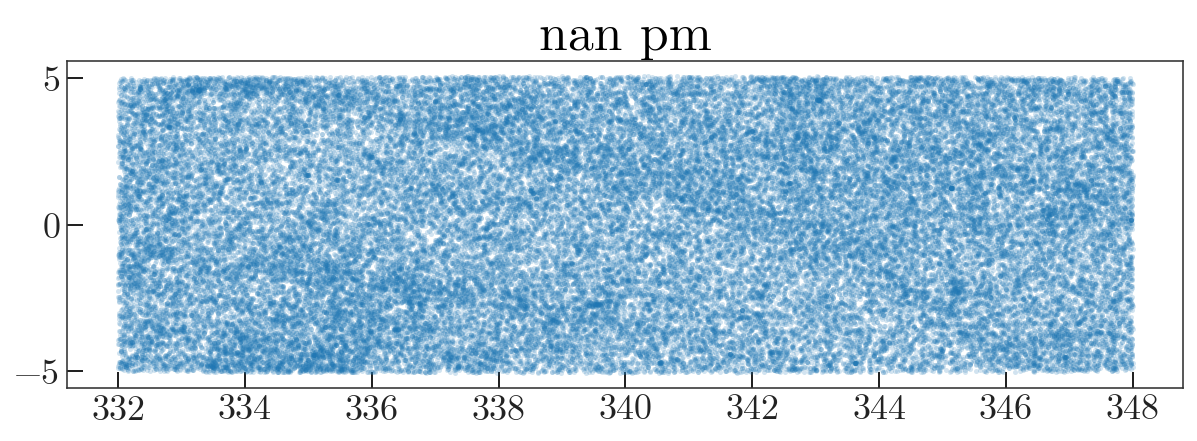

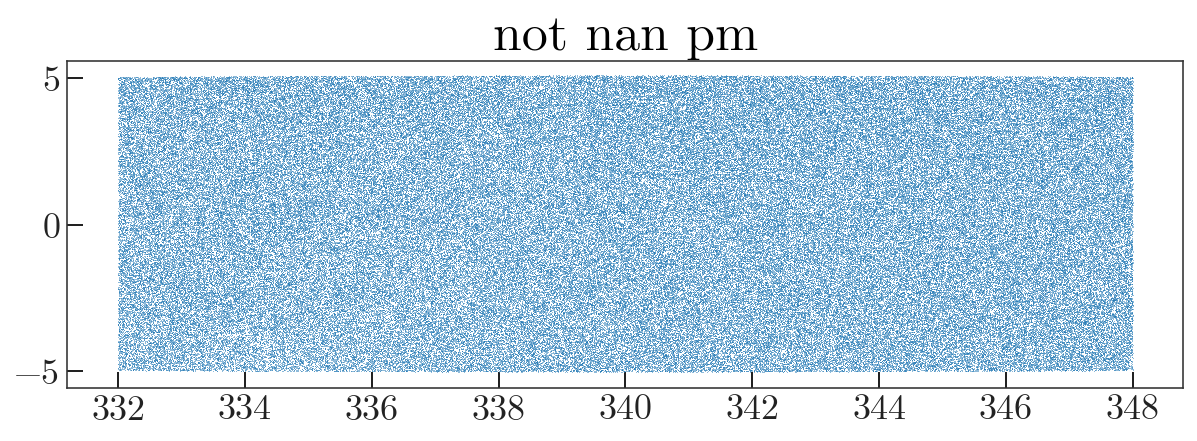

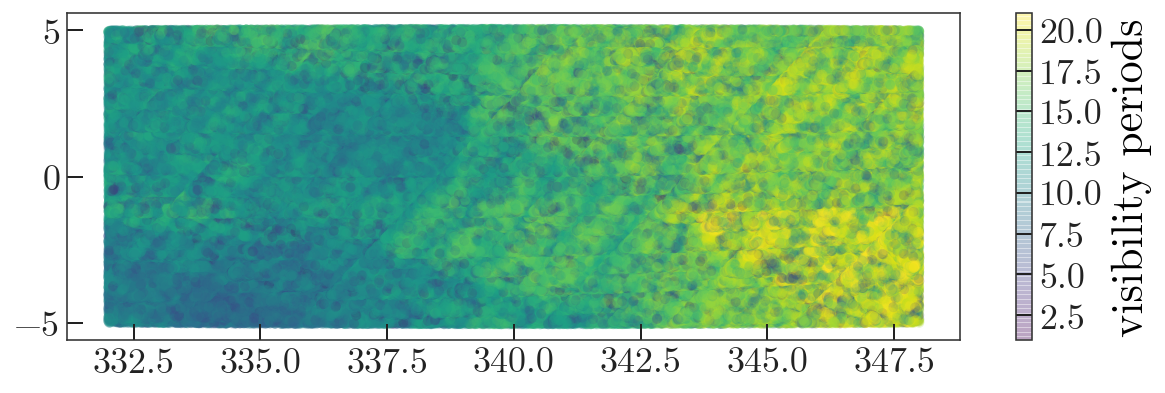

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(scan_c.phi1.degree[nan_mask], 
        scan_c.phi2.degree[nan_mask], 
        marker='.', linestyle='none', alpha=0.2)
ax.set_title('nan pm')

fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(scan_c.phi1.degree[~nan_mask], 
        scan_c.phi2.degree[~nan_mask], 
        marker=',', linestyle='none', alpha=0.5)
ax.set_title('not nan pm')

fig, ax = plt.subplots(1, 1, figsize=(10, 3))
cs = ax.scatter(scan_c.phi1.degree, 
           scan_c.phi2.degree, 
           c=scan.visibility_periods_used,
           alpha=0.2, linewidth=0)
cb = fig.colorbar(cs)
cb.set_label('visibility periods')

---

In [36]:
g = GaiaData(Table.read('gd1_tbl.fits'))
gd1_gal = coord.Galactic(l=g[g.parallax>0].skycoord.galactic.l,
                         b=g[g.parallax>0].skycoord.galactic.b)

(0, 80)

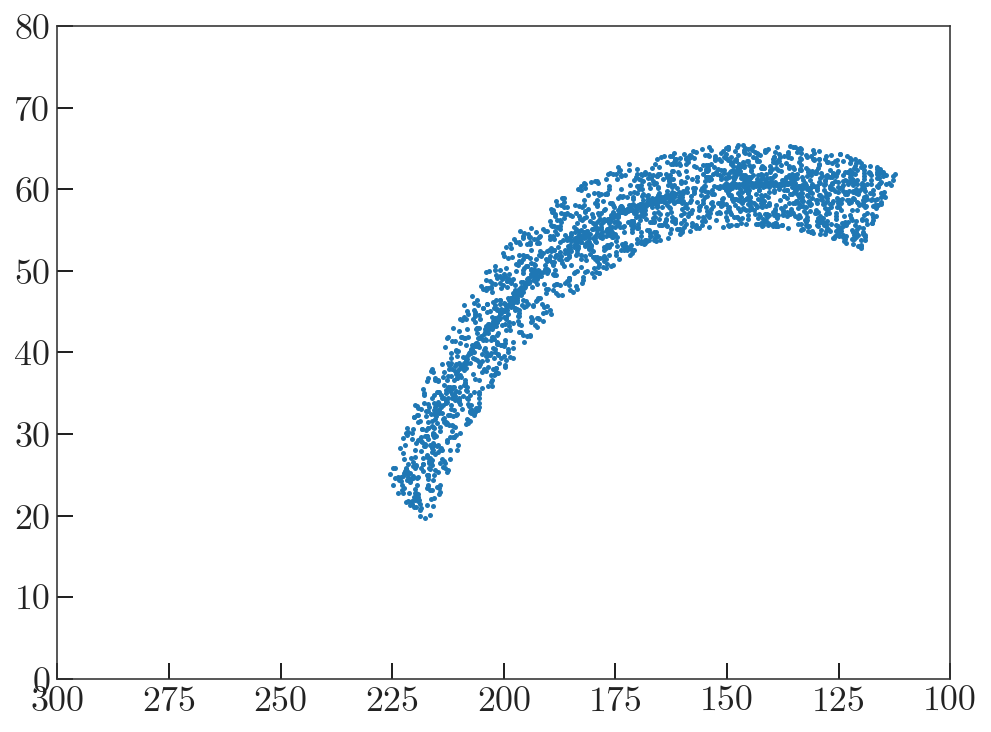

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(gd1_gal.l.degree, gd1_gal.b.degree, marker='.', linestyle='none')
ax.set_xlim(300, 100)
ax.set_ylim(0, 80)

In [16]:
l0, b0 = (170., 37.)
l = np.arange(l0 - 50., l0 + 50., 0.1)
b = np.arange(b0 - 50., b0 + 50., 0.1)
l, b = np.meshgrid(l, b)
coords = coord.SkyCoord(l*u.deg, b*u.deg,
                        distance=1.*u.kpc, frame='galactic')

In [17]:
sfd = SFDQuery()
Av_sfd = 2.742 * sfd(coords)

In [37]:
phi1 = np.linspace(280, 360, 1024) * u.degree
phi2 = np.full(len(phi1), 1) * phi1.unit
gd1_hull1 = gc.GD1(phi1=phi1, phi2=phi2).transform_to(coord.Galactic)

phi2 = np.full(len(phi1), -1) * phi1.unit
gd1_hull2 = gc.GD1(phi1=phi1, phi2=phi2).transform_to(coord.Galactic)

gd1_gap = gc.GD1(phi1=[338, 338, 342, 342]*u.deg, 
                 phi2=[-1, 1, -1, 1]*u.deg).transform_to(coord.Galactic)
gd1_underd = gc.GD1(phi1=[316, 316, 324, 324]*u.deg, 
                    phi2=[-1, 1, -1, 1]*u.deg).transform_to(coord.Galactic)

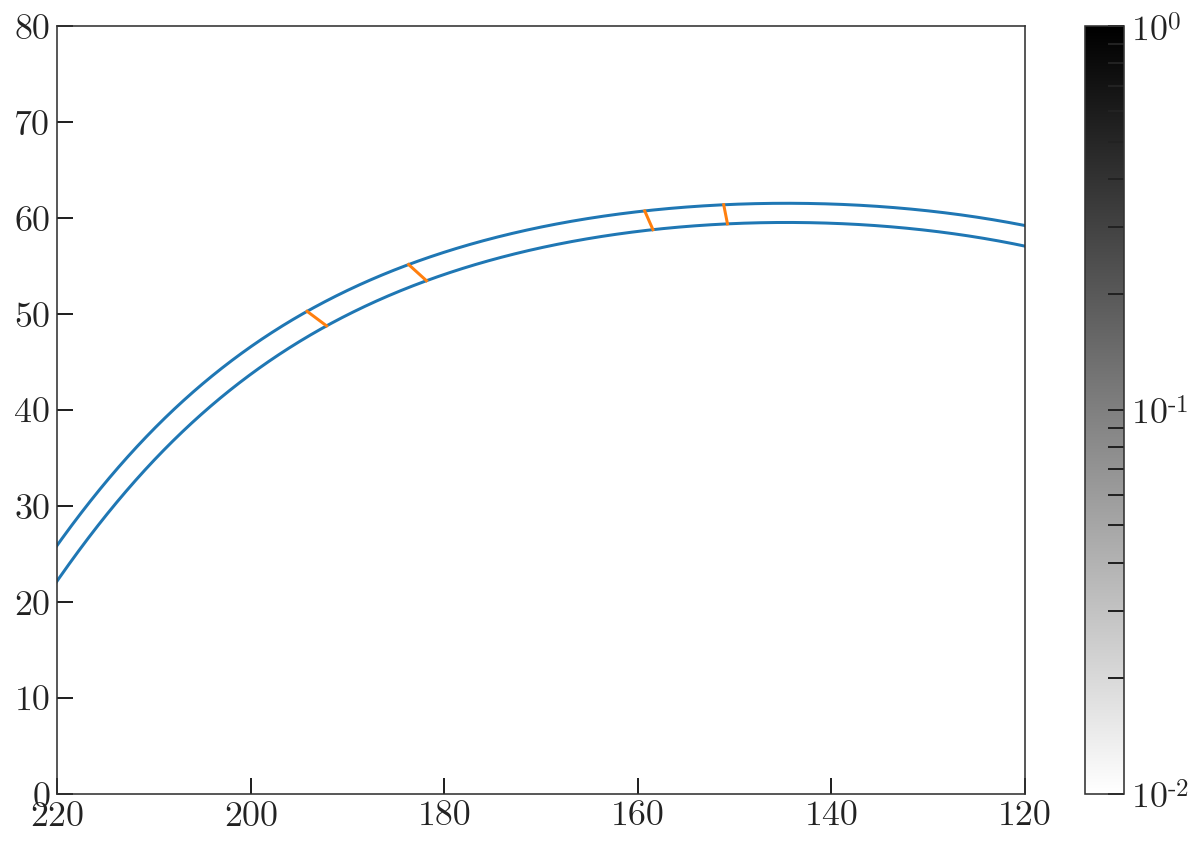

In [95]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))

# ax.pcolormesh(l, b, 
#    Av_sfd[::,::-1],
#    vmin=0.,
#    vmax=4.,
#    cmap='binary'
# )
c = ax.pcolormesh(l, b, 
   Av_sfd[::,::-1],
   cmap='binary',
   norm=mpl.colors.LogNorm(vmin=1E-2, vmax=1e0)
)

ax.plot(gd1_hull1.l.degree, gd1_hull1.b.degree, 
        marker='', color='tab:blue')
ax.plot(gd1_hull2.l.degree, gd1_hull2.b.degree, 
        marker='', color='tab:blue')

ax.plot(gd1_gap.l.degree[:2], gd1_gap.b.degree[:2], 
        marker='', color='tab:orange')
ax.plot(gd1_gap.l.degree[2:], gd1_gap.b.degree[2:], 
        marker='', color='tab:orange')

ax.plot(gd1_underd.l.degree[:2], gd1_underd.b.degree[:2], 
        marker='', color='tab:orange')
ax.plot(gd1_underd.l.degree[2:], gd1_underd.b.degree[2:], 
        marker='', color='tab:orange')

ax.set_xlim(220, 120)
ax.set_ylim(0, 80)

fig.colorbar(c)

fig.tight_layout()

---

GD1 coordinates

In [7]:
l = np.arange(279.5, 360.5, 0.1)
b = np.arange(-5.2, 5.2, 0.1)
l, b = np.meshgrid(l, b)
l = coord.Angle(l*u.deg)
b = coord.Angle(b*u.deg)
coords = coord.SkyCoord(l, b,
                        distance=1.*u.kpc, frame=gc.GD1)

sfd = SFDQuery()
Av_sfd = 2.742 * sfd(coords)

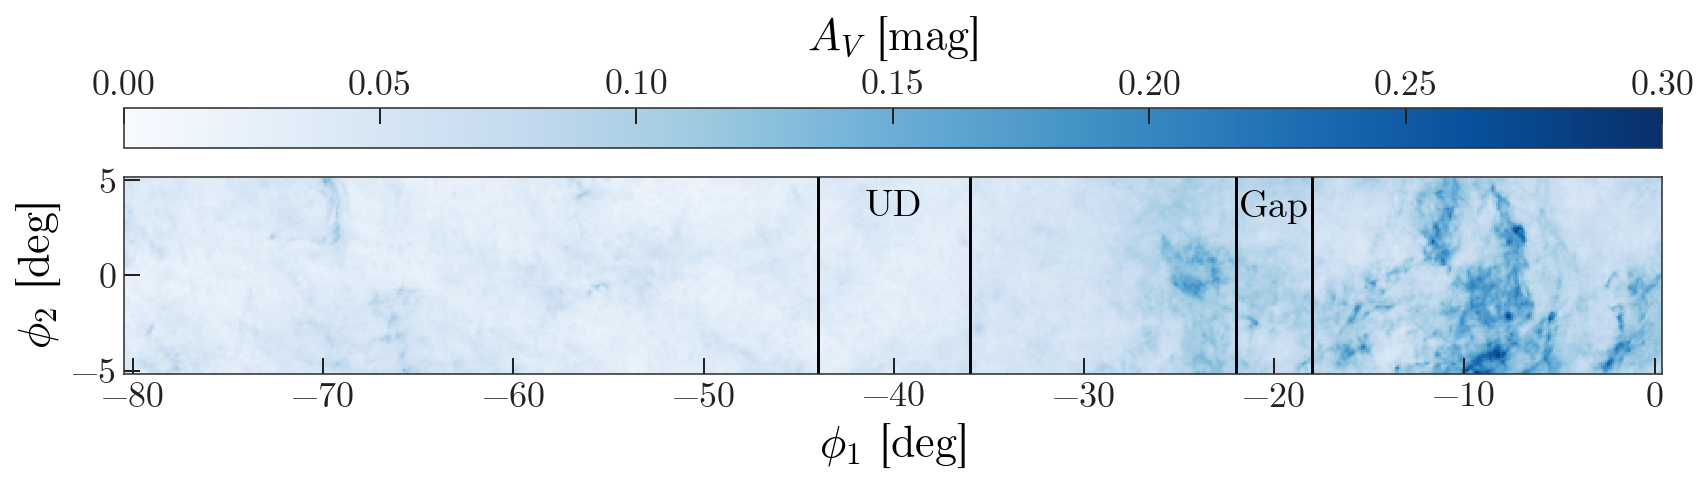

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3.5))

l_ = l.wrap_at(180*u.deg).degree
c = ax.pcolormesh(l_, b, 
   Av_sfd[::,::-1],
   cmap='Blues',
   # norm=mpl.colors.LogNorm(vmin=1E-2, vmax=1e0),
   norm=mpl.colors.Normalize(vmin=0, vmax=0.3),
   rasterized=True
)

for v in gap_phi1.wrap_at(180*u.deg).value:
    ax.axvline(v, color='k', marker='')
    
for v in udens_phi1.wrap_at(180*u.deg).value:
    ax.axvline(v, color='k', marker='')

div = make_axes_locatable(ax)
cax = div.append_axes("top", size="20%", pad=0.2)
cb = fig.colorbar(c, cax=cax, orientation='horizontal')
cb.ax.xaxis.set_ticks_position('top')

cb.set_label('$A_V$ [mag]', labelpad=10)
cb.ax.xaxis.set_label_position('top')

ax.set_xlim(l_.min(), l_.max())
ax.set_ylim(-5.2, 5.2)

ax.set_xlabel(r'$\phi_1$ [deg]')
ax.set_ylabel(r'$\phi_2$ [deg]')

ax.text(-40, 4.5, 'UD', ha='center', va='top', fontsize=19)
ax.text(-20, 4.5, 'Gap', ha='center', va='top', fontsize=19)

fig.tight_layout()
ax.set_aspect('equal')

fig.savefig('../paper/sfd.pdf', dpi=250)

0.027522027


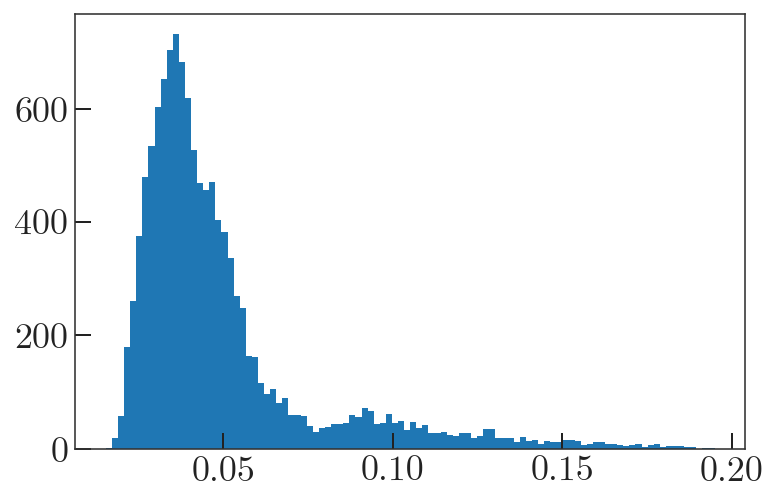

In [15]:
l = np.arange(-60, 0, 0.1)
b = np.arange(-1, 1, 0.1)
l, b = np.meshgrid(l, b)
l = coord.Angle(l*u.deg)
b = coord.Angle(b*u.deg)
coords = coord.SkyCoord(l, b, distance=1.*u.kpc, 
                        frame=gc.GD1)
sfd = SFDQuery()
A_V = 2.742 * sfd(coords)
print(np.std(A_V))

plt.hist(A_V.ravel(), bins='auto');

In [9]:
for region in [gap_phi1, udens_phi1]:
    l = np.arange(region.min().value, region.max().value, 0.1)
    b = np.arange(-1, 1, 0.1)
    l, b = np.meshgrid(l, b)
    l = coord.Angle(l*u.deg)
    b = coord.Angle(b*u.deg)
    coords = coord.SkyCoord(l, b, distance=1.*u.kpc, 
                            frame=gc.GD1)

    sfd = SFDQuery()
    print(np.max(2.742 * sfd(coords)))

0.07778956
0.06353467
